# National Center for Atmospheric Research
# California Seasonal Rainfall Prediction Starting Kit
David John Gagne II

## Introduction

### Requirements
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn

## NCAR Last Millennium Ensemble


## The Data
* TS: temperature at the surface (K)
* PSL: mean sea level pressure (Pa) (not Pumpkin Spice Lattes!)
* TMQ: precipitable water (mm)
* U_500: west-east component of the wind at the 500 mb pressure level (m/s)
* V_500: south-north component of the wind at the 500 mb pressure level (m/s)
* Z3_500: geopotential height of the 500 mb pressure level (m)

The goal is to predict the amount of rainfall in northern California from December through February given monthly averaged atmospheric fields from the previous November.

In [18]:
%matplotlib inline
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import cartopy.crs as ccrs
from ipywidgets import interact

In [2]:
def read_data(path, f_prefix):
    data_vars = ["TS", "PSL", "TMQ", "U_500", "V_500", "Z3_500"]
    X_coll = []
    for data_var in data_vars:
        nc_file = join(path, "data", f_prefix + "_{0}.nc".format(data_var))
        print(nc_file)
        ds = xr.open_dataset(nc_file, decode_times=False)
        ds.load()
        X_coll.append(ds[data_var].stack(enstime=("ens", "time")).transpose("enstime", "lat", "lon"))
        ds.close()
    X_ds = xr.merge(X_coll)
    y = pd.read_csv(join(path, "data", f_prefix + "_precip_90.csv"), index_col="Year")
    y_array = np.concatenate([y[c] for c in y.columns])
    return X_ds, y_array

In [3]:
train_X, train_y = read_data("./", "train")

./data/train_TS.nc
./data/train_PSL.nc
./data/train_TMQ.nc
./data/train_U_500.nc
./data/train_V_500.nc
./data/train_Z3_500.nc


In [35]:
train_X["TS"].sel(ens=0, time=334.0).shape

(96, 144)

In [52]:
years = np.arange(850, 2005)
def plot_grid(ens, year, var):
    ti = np.where(year == years)[0][0]
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    ax.coastlines()
    min_val = train_X[var].min()
    max_val = train_X[var].max()
    cont = ax.contourf(train_X["lon"] - 180, train_X["lat"], 
                       train_X[var].sel(ens=ens, time=train_X["time"].values[ti]),
                       np.linspace(min_val, max_val, 20))
    ax.set_title(var + " " + "Year: {0:d} Member {1}".format(year, ens))
    plt.colorbar(cont)
interact(plot_grid, ens=[0, 1, 2, 3], year=SelectionSlider(options=years.tolist()), 
         var=["TS", "PSL", "TMQ", "U_500", "V_500", "Z3_500"])

A Jupyter Widget

<function __main__.plot_grid>

(array([ 4158.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   462.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

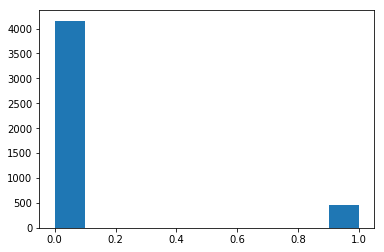

In [55]:
plt.hist(train_y)